In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [3]:
log_dirs = [
    #'/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-14:34:39_SCRUB'
    '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange'
    # '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-29-17:50:31_SCRUB'
    ]

log_dirs_dict = {
    'SCRUB': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-29-17:50:31_SCRUB',
    'neggradplus': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-29-18:01:21_neggradplus',
    'our_method': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange'
}

methods = ['Our Costrained Approach']

In [4]:
markers = ['*', 'd', 'o', '>', '.', '<', 'D']

# Downloading the dataset

In [5]:
import data

In [6]:
# Define CIFAR100 dataset handler
dataset_handler = data.CIFAR100Handler(batch_size=128,
                                           validation_split=0.1,
                                           random_seed=42,
                                           data_dir='/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100')
# data_confuser = data.uniform_confuser(confuse_level=.0, random_seed=42)
data_confuser = data.uniform_confuser(confuse_level=.1, random_seed=42)
splitter = data.mix_both_sets(
        amend_split=1.,
        # retain_split=0.1,
        retain_split=0.,
        random_seed=42
        )
confused_dataset_handler = data.AmendedDatasetHandler(
        dataset_handler,
        data_confuser,
        splitter
        )
train_loader, val_loader, test_loader, forget_loader, \
retain_loader, unseen_loader = confused_dataset_handler.get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


# Accuracy @ 5 on the retained set plots

In [7]:
all_values_retain = []
for log_dir in log_dirs:
    # log_dir = log_dir + '/Accuracy_train_top5_retain'
    log_dir += '/Accuracy_top5_condition'
    print(log_dir)
    # Initialize the event accumulator
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Print all available tags (e.g., scalars, histograms, images, etc.)
    print(event_acc.Tags())

    # Get scalar data for a specific tag
    scalar_tag = 'Accuracy/top5'  # Change to the tag you are interested in
    # scalar_tag = 'Accuracy/train_top5'  # Change to the tag you are interested in
    scalar_events = event_acc.Scalars(scalar_tag)

    # Extract steps and values
    epochs = [event.step for event in scalar_events]
    values = [event.value for event in scalar_events]

    all_values_retain.append(values)

/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange/Accuracy_top5_condition
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [8]:
all_values_retain[0]

[99.7802734375,
 99.6337890625,
 99.3896484375,
 93.1884765625,
 90.3076171875,
 90.966796875,
 90.869140625,
 87.255859375]

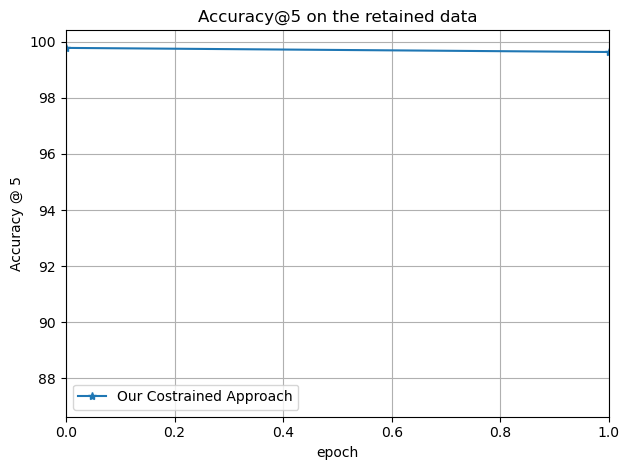

In [9]:
for value, method, marker in zip(all_values_retain, methods, markers):
    plt.plot(np.arange(len(all_values_retain[0])), value, label=method, marker=marker)

plt.xlabel('epoch')
plt.ylabel('Accuracy @ 5')
plt.grid()
# plt.ylim(bottom=20, top=100)
plt.xlim(left=0, right=len(all_values_retain))
plt.title('Accuracy@5 on the retained data')
plt.legend()
plt.tight_layout()
# plt.savefig('/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/plots/acc_5_retain.pdf')

# Accuracy @ 5 on the forget set

In [10]:
all_values_forget = []
for log_dir in log_dirs:
    log_dir = log_dir + '/Accuracy_top5_objective'
    # log_dir = log_dir + '/Accuracy_train_top5_forget'
    print(log_dir)
    # Initialize the event accumulator
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Print all available tags (e.g., scalars, histograms, images, etc.)
    print(event_acc.Tags())

    # Get scalar data for a specific tag
    # scalar_tag = 'Accuracy/train_top5'  # Change to the tag you are interested in
    scalar_tag = 'Accuracy/top5'  # Change to the tag you are interested in
    scalar_events = event_acc.Scalars(scalar_tag)

    # Extract steps and values
    epochs = [event.step for event in scalar_events]
    values = [event.value for event in scalar_events]

    all_values_forget.append(values)

/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange/Accuracy_top5_objective
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [11]:
from models import get_model
from metrics import calculate_accuracy
import torch

/ibex/scratch/gasanoe/unlearning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = get_model('resnet18', num_classes=100, pretrained_weights=None,
                  weight_path=log_dirs[-1]+'_model.pth')
device = torch.device('cuda')
model.to(device)
print('Model is loaded')

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.025_untrain07-24-15:52:07_constrained_lagrange_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Model is loaded


In [12]:
import matplotlib.colors as mcolors

In [13]:
all_values_forget = np.array(all_values_forget[0])
all_values_retain = np.array(all_values_retain[0])

In [14]:
all_values_retain

array([99.78027344, 99.63378906, 99.38964844, 93.18847656, 90.30761719,
       90.96679688, 90.86914062, 87.25585938])

In [15]:
from matplotlib.collections import PolyCollection

In [16]:
plt.rcParams.update({'font.size': 16})

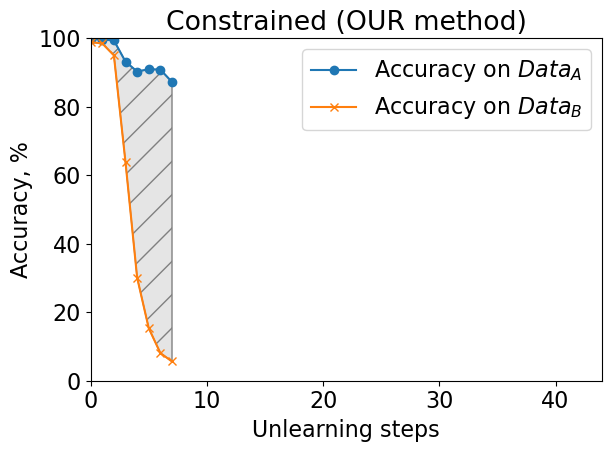

In [20]:
marker = ['o', 'x']

num_points = len(all_values_forget)

x = np.arange(num_points)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, all_values_retain, label=r'Accuracy on $Data_A$', marker=marker[0])
ax.plot(x, all_values_forget, label=r'Accuracy on $Data_B$', marker=marker[1])

# Fill the space between the two lines with angled lines (hatching)
ax.fill_between(x, all_values_retain, all_values_forget, color=(0.5, 0.5, 0.5, 0.2), hatch='/', edgecolor='gray')

# Labels and grid
ax.set_xlabel('Unlearning steps')
ax.set_ylabel('Accuracy, %')
ax.set_ylim(bottom=0, top=100)
# ax.grid()
ax.set_xlim(left=0, right=44)
# ax.set_xticks(np.arange(0, num_points, 1))
ax.legend()
ax.set_title('Constrained (OUR method)')
plt.tight_layout()

# Save or show the plot
# plt.savefig('plots/scrub_plot_for_presentation.pdf')
# plt.savefig('plots/constrained_plot_for_presentation.pdf')
plt.show()